In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
sj = pd.read_excel('SanJuan_all.xlsx')
iq = pd.read_excel('Iquitos_all.xlsx')
sub = pd.read_csv('submission_format.csv')

In [3]:
sj = sj.set_index('Unnamed: 0')
iq = iq.set_index('Unnamed: 0')
sj_y = sj.pop('total_cases')
iq_y = iq.pop('total_cases')

In [4]:
sj.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
Unnamed: 0,,,,,,,,,,,,,,,,,,,,
1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [5]:
# Replace Null with Month Mean
def mean_replace(data):
    monthly = dict()
    for month in range(1,13):
        monthly[month] = data[data.index.month == month]
        for col in monthly[month]:
            monthly[month][col] = monthly[month][col].fillna(np.mean(monthly[month][col]))
    new = pd.DataFrame(columns=data.columns)
    #for num in monthly.keys():
    #    new = np.vstack([new, monthly[num]])
    templist = list()
    for a in monthly.keys():
        templist.append(monthly[a])
    result = pd.concat(templist).sort_index()
    return result

In [6]:
month_sj = mean_replace(sj)
month_iq = mean_replace(iq)

In [7]:
log_sjy = np.log1p(sj_y)
log_iqy = np.log1p(iq_y)

# Split data into training set and testing set, regarding the number of lags.

In [8]:
def lag_split(data_x, data_y, lag):
    # Count number of original training by count the number of total_cases which is not NA
    test_no = data_y.isna().sum()
    train_no = data_x.shape[0] - test_no
    
    x_train_ = data_x.iloc[:train_no - lag]
    x_test_ = data_x.iloc[train_no - lag: train_no + test_no - lag]
    
    y_train_ = data_y[lag:].dropna()
    return x_train_, x_test_, y_train_

In [9]:
xx1, xx2, y1 = lag_split(month_sj, log_sjy, lag = 4)

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

Using TensorFlow backend.


In [11]:
model1 = Sequential()
model1.add(Dense(units = 64, kernel_initializer = 'uniform',
                activation = 'relu', input_dim = xx1.shape[1]))
model1.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model1.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
model1.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'linear'))

sgd = optimizers.SGD(lr = 0.001, decay = 1, momentum = 0.99)
model1.compile(optimizer = sgd, loss = 'mae', metrics = ['accuracy'])

In [12]:
# San Juan
#model1.fit(xx1, y1, epochs = 20, batch_size=2, verbose = 1)

In [13]:
iq1, iq2, iq_y = lag_split(month_iq, log_iqy, lag = 3)

In [14]:
model2 = Sequential()
model2.add(Dense(units = 64, kernel_initializer = 'uniform',
                activation = 'relu', input_dim = iq1.shape[1]))
model2.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model2.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
model2.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'linear'))
model2.compile(optimizer = 'adam', loss = 'mae', metrics = ['accuracy'])

In [15]:
# San Juan
#model2.fit(iq1, iq_y, epochs = 20, batch_size=2, verbose = 1)

In [16]:
sj_result = model1.predict(xx2)
iq_result = model2.predict(iq2)

In [17]:
tot_result = np.vstack([sj_result, iq_result])
tot_result = [(np.exp(x) - 1) for x in tot_result]

In [18]:
sub.total_cases = [int(x) for x in tot_result]

In [19]:
sub.to_csv('NN05.csv', index = False)

# Approach 2: train_test_split within the training data

In [148]:
sj = pd.read_excel('SanJuan_all.xlsx', index_col = 'Unnamed: 0')
iq = pd.read_excel('Iquitos_all.xlsx', index_col = 'Unnamed: 0')
sub = pd.read_csv('submission_format.csv')

In [149]:
sj_used = sj[~sj.total_cases.isnull()]
iq_used = iq[~iq.total_cases.isnull()]

sj_y = sj_used.pop('total_cases')
iq_y = iq_used.pop('total_cases')

In [150]:
sj_used.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [151]:
month_sj = mean_replace(sj_used)
month_iq = mean_replace(iq_used)

In [152]:
def lag_split2(data, target, lag):
    x_ = data.iloc[:-lag].reset_index()
    y_ = target.iloc[lag:].reset_index()
    return x_, y_

In [208]:
lag = 4
x = month_sj.iloc[:-lag].reset_index().drop('index', axis = 1)
y = sj_y.iloc[lag:].reset_index().drop('index', axis = 1)

In [209]:
train_size = np.int(0.7 * x.shape[0])
x_train, x_test = x.iloc[:train_size], x.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [93]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

In [94]:
model1 = Sequential()
model1.add(Dense(units = 64, kernel_initializer = 'uniform',
                activation = 'relu', input_dim = x_train.shape[1]))
model1.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model1.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
model1.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'linear'))

sgd = optimizers.SGD(lr = 0.001, decay = 1, momentum = 0.99)
model1.compile(optimizer = sgd, loss = 'mae', metrics = ['accuracy'])

In [95]:
# Iquitos
model1.fit(x_train, y_train, epochs = 20, batch_size=2, verbose = 1)

Epoch 1/20
361/361 [==============================] - 1s 1ms/step - loss: 5.5780 - accuracy: 0.0776
Epoch 2/20
361/361 [==============================] - 0s 539us/step - loss: 5.5545 - accuracy: 0.0554
Epoch 3/20
361/361 [==============================] - 0s 561us/step - loss: 5.4310 - accuracy: 0.0970
Epoch 4/20
361/361 [==============================] - 0s 549us/step - loss: 5.4812 - accuracy: 0.0693
Epoch 5/20
361/361 [==============================] - 0s 555us/step - loss: 5.4148 - accuracy: 0.0526
Epoch 6/20
361/361 [==============================] - 0s 542us/step - loss: 5.3574 - accuracy: 0.0637
Epoch 7/20
361/361 [==============================] - 0s 548us/step - loss: 5.4113 - accuracy: 0.0665
Epoch 8/20
361/361 [==============================] - 0s 552us/step - loss: 5.3528 - accuracy: 0.0582
Epoch 9/20
361/361 [==============================] - 0s 573us/step - loss: 5.3645 - accuracy: 0.0609
Epoch 10/20
361/361 [==============================] - 0s 548us/step - loss: 5.3659 

In [96]:
result1 = model1.predict(x_test).reshape(-1)
result1 = [int(x) for x in result1]

In [97]:
y_compared = y_test.copy()
y_compared['predicted'] = result1
y_compared.head()

,total_cases,predicted
361,4.0,3
362,1.0,4
363,8.0,3
364,5.0,3
365,3.0,3


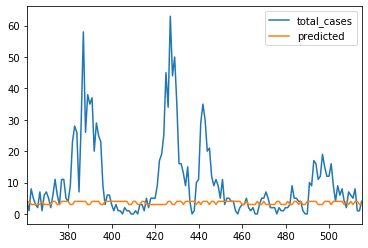

In [98]:
y_compared.plot()

In [99]:
def mae(data):
    total_error = 0
    for i in range(data.shape[0]):
        total_error += np.abs(data.iloc[i][0] - data.iloc[i][1])
    return total_error / data.shape[0]

In [100]:
mae(y_compared)

7.84516129032258

# Other regression methods

## Linear Regression 

In [101]:
from sklearn.linear_model import LinearRegression

In [102]:
reg = LinearRegression()
linreg = reg.fit(x_train, y_train)

In [103]:
#linreg.predict(x_test)
y_linreg = y_test.copy()
y_linreg['predicted'] = linreg.predict(x_test)

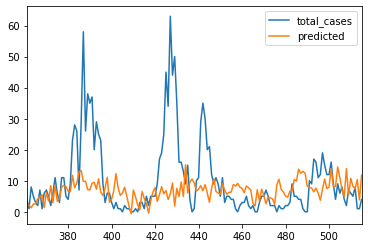

In [104]:
y_linreg.plot()

In [105]:
mae(y_linreg)

7.824983856828684

## Support Vector Regression

In [106]:
from sklearn.svm import SVR

In [107]:
svr_lin = SVR(kernel = 'linear')
#svr_rbf = SVR()
#svr_poly = SVR(kernel = 'poly')

In [165]:
svr_lin_fit = svr_lin.fit(x_train, y_train)
svr_rbf_fit = svr_rbf.fit(x_train, y_train)
#svr_poly_fit = svr_poly.fit(x_train, y_train)
y_svr = y_test.copy()
y_svr['predicted'] = svr_lin_fit.predict(x_test)
#y_svr['poly'] = svr_poly_fit.predict(x_test)
#y_svr['rbf'] = svr_rbf_fit.predict(x_test)

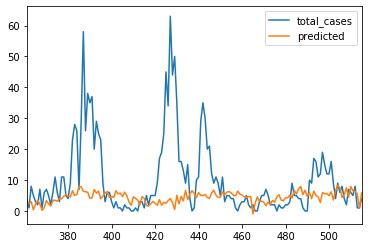

In [166]:
y_svr.plot()

In [110]:
mae(y_svr)

7.808518479856457

## Polynomial Regression

In [111]:
polyreg = LinearRegression()

In [112]:
from sklearn.preprocessing import PolynomialFeatures

In [113]:
quad = PolynomialFeatures(degree = 2)
x_quad_train = quad.fit_transform(x_train)
x_quad_test = quad.transform(x_test)

In [114]:
polyreg_fit = polyreg.fit(x_quad_train, y_train)

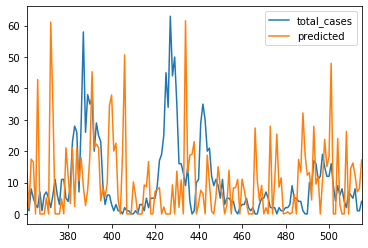

In [115]:
y_poly = y_test.copy()
y_poly_pred = polyreg_fit.predict(x_quad_test).reshape(-1)
y_poly['predicted'] = [max(0, i) for i in y_poly_pred]
y_poly.plot()

In [116]:
mae(y_poly)

11.74010008688896

## RANSAC Regression

In [117]:
from sklearn.linear_model import RANSACRegressor

In [118]:
ransac = RANSACRegressor(LinearRegression(), max_trials = 100, min_samples = 10)
ransac_fit = ransac.fit(x_train, y_train)
y_ransac = y_test.copy()
y_ransac['predicted'] = ransac_fit.predict(x_test).reshape(-1)

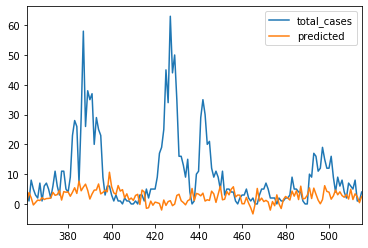

In [119]:
y_ransac.plot()

In [120]:
mae(y_ransac)

8.55995473818691

## For-Loop Neural Network

In [121]:
def nn_loop(data, target, testing):
    x_train = data.copy()
    y_train = target.copy()
    result = list()

    sgd = optimizers.SGD(lr = 0.001, decay = 1, momentum = 0.99)
    
    model_z = Sequential()
    model_z.add(Dense(units = 64, kernel_initializer = 'uniform',
                    activation = 'relu', input_dim = x_train.shape[1]))
    #model_z.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
    #model_z.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
    model_z.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'linear'))
    model_z.save_weights('model.h5')
    model_z.compile(optimizer = sgd, loss = 'mae', metrics = ['accuracy'])
    
    _ = 0
    for i in range(testing.shape[0]):
        model_z.load_weights('model.h5')
        model_z.fit(x_train, y_train, epochs=3)
        pred = model_z.predict(testing.iloc[0:1])
        #print(pred)
        result.append(int(pred[0][0]))
        
        # Reset training and testing datasets
        x_train = np.vstack((x_train[1:], testing.iloc[0:1]))
        testing = testing.iloc[1:]
        y_train = np.vstack((y_train[1:], int(pred[0][0])))
        
        # Error prevention code
        #_ += 1
        #if _ > 5:
        #    break
    return result

In [159]:
#loop_result = nn_loop(x_train, y_train, x_test)

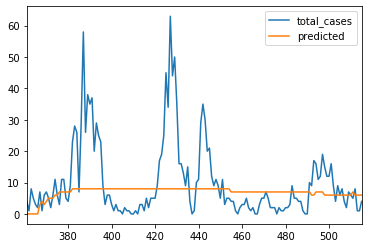

In [123]:
y_nnloop = y_test.copy()
#y_nnloop['predicted'] = loop_result
y_nnloop.plot()

In [158]:
#loop_result

# Combining several regression techniques

7.879457907154284

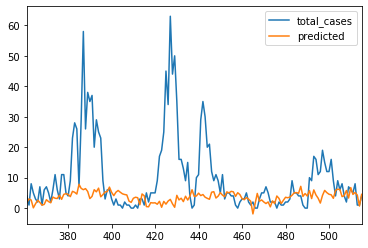

In [167]:
y_RansacSvr = y_test.copy()
y_RansacSvr['predicted'] = y_svr.predicted * 0.6 + y_ransac.predicted * 0.4
y_RansacSvr.plot()
mae(y_RansacSvr)

In [169]:
mae(y_RansacSvr)

7.879457907154284

## Optimize?

In [ ]:
ratio = 1
step = 0.2
y_RansacSvr['predicted'] = y_svr.predicted * ratio + y_ransac.predicted * (1 - ratio)
current_mae = mae(y_RansacSvr)

def ratio_calculate(ratio):
    return y_svr.predicted * ratio + y_ransac.predicted * (1 - ratio)

def mae2(y_test, predicted):
    error = 0
    for i in range(y_test.shape[0]):
        error += np.abs(y_test.iloc[i] - predicted.iloc[i])
    return error / y_test.shape[0]
'''
for i in range(20):
    #print(i)
    current_error = mae2(y_test, ratio_calculate(ratio))
    if (mae2(y_test, ratio_calculate(ratio + step)) > current_error).values[0]:
        current_error = mae2(y_test, ratio_calculate(ratio - step/(i+1)))
    else:
        current_error = mae2(y_test, ratio_calculate(ratio + step/(i+1)))
    print(current_error)
'''
print(current_mae)

# Linear SVR

In [210]:
svr = SVR(kernel = 'linear')

In [211]:
#sj_stacked = np.vstack((x_train, x_test))
#sj_targets = np.vstack((y_train, y_test))
x.head()

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [212]:
sj_test = sj[sj.total_cases.isnull()].drop('total_cases', axis = 1)
sj_test = mean_replace(sj_test)

In [213]:
svr_fit = svr.fit(x, y)
sj_svr_pred = svr_fit.predict(sj_test)
sj_svr_pred = [int(i) for i in sj_svr_pred]

In [206]:
svr = SVR(kernel = 'linear')
iq_stacked = np.vstack((x_train, x_test))
iq_targets = np.vstack((y_train, y_test))
iq_test = iq[iq.total_cases.isnull()].drop('total_cases', axis = 1)
iq_test = mean_replace(iq_test)

In [207]:
svr_fit = svr.fit(iq_stacked, iq_targets)
iq_svr_pred = svr_fit.predict(iq_test)
iq_svr_pred = [int(i) for i in iq_svr_pred]

In [214]:
total_pred = sj_svr_pred.copy()
total_pred.extend(iq_svr_pred)

In [215]:
sub.total_cases = total_pred

In [218]:
sub.to_csv('SVR_trimmed.csv', index = False)

In [192]:
sj_temp1 = month_sj.iloc[-lag:].reset_index().drop('index', axis = 1)
sj_temp2 = sj[sj.total_cases.isnull()].iloc[:-lag].drop('total_cases', axis = 1)
sj_temp2 = mean_replace(sj_temp2)
sj_valid = np.vstack((sj_temp1, sj_temp2))

In [193]:
iq_temp1 = month_iq.iloc[-lag:].reset_index().drop('index', axis = 1)
iq_temp2 = iq[iq.total_cases.isnull()].iloc[:-lag].drop('total_cases', axis = 1)
iq_temp2 = mean_replace(iq_temp2)
iq_valid = np.vstack((iq_temp1, iq_temp2))

In [196]:
sj_valid.shape

(260, 20)

In [197]:
iq_valid.shape

(156, 20)